In [1]:
import os
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
# num_epochs = 200
num_epochs = 100
batch_size = 100
sample_dir = 'samples'
# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [4]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [5]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i + 1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Save real images
    if epoch == 0:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(images, os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch + 1)))

Epoch [0/100], Step [200/600], d_loss: 0.2556, g_loss: 3.3429, D(x): 0.88, D(G(z)): 0.11
Epoch [0/100], Step [400/600], d_loss: 0.9020, g_loss: 6.1518, D(x): 0.65, D(G(z)): 0.24
Epoch [0/100], Step [600/600], d_loss: 0.1851, g_loss: 4.0662, D(x): 0.90, D(G(z)): 0.07
Epoch [1/100], Step [200/600], d_loss: 0.0802, g_loss: 3.7375, D(x): 0.97, D(G(z)): 0.04
Epoch [1/100], Step [400/600], d_loss: 0.9817, g_loss: 1.8282, D(x): 0.60, D(G(z)): 0.28
Epoch [1/100], Step [600/600], d_loss: 0.6972, g_loss: 2.0111, D(x): 0.74, D(G(z)): 0.24
Epoch [2/100], Step [200/600], d_loss: 0.5943, g_loss: 2.3138, D(x): 0.76, D(G(z)): 0.21
Epoch [2/100], Step [400/600], d_loss: 0.5811, g_loss: 2.1785, D(x): 0.80, D(G(z)): 0.26
Epoch [2/100], Step [600/600], d_loss: 0.3936, g_loss: 2.3560, D(x): 0.87, D(G(z)): 0.19
Epoch [3/100], Step [200/600], d_loss: 0.2284, g_loss: 3.3482, D(x): 0.91, D(G(z)): 0.07
Epoch [3/100], Step [400/600], d_loss: 0.1207, g_loss: 4.0366, D(x): 0.95, D(G(z)): 0.04
Epoch [3/100], Step [

Epoch [30/100], Step [600/600], d_loss: 0.1439, g_loss: 6.8057, D(x): 0.95, D(G(z)): 0.03
Epoch [31/100], Step [200/600], d_loss: 0.1116, g_loss: 7.6276, D(x): 0.97, D(G(z)): 0.04
Epoch [31/100], Step [400/600], d_loss: 0.0464, g_loss: 7.8393, D(x): 0.99, D(G(z)): 0.00
Epoch [31/100], Step [600/600], d_loss: 0.0570, g_loss: 8.1773, D(x): 0.98, D(G(z)): 0.01
Epoch [32/100], Step [200/600], d_loss: 0.0459, g_loss: 6.5897, D(x): 0.99, D(G(z)): 0.03
Epoch [32/100], Step [400/600], d_loss: 0.1269, g_loss: 5.8357, D(x): 0.96, D(G(z)): 0.03
Epoch [32/100], Step [600/600], d_loss: 0.1365, g_loss: 6.4759, D(x): 0.99, D(G(z)): 0.08
Epoch [33/100], Step [200/600], d_loss: 0.0387, g_loss: 6.1881, D(x): 0.99, D(G(z)): 0.02
Epoch [33/100], Step [400/600], d_loss: 0.1100, g_loss: 5.3801, D(x): 0.97, D(G(z)): 0.03
Epoch [33/100], Step [600/600], d_loss: 0.1779, g_loss: 7.8543, D(x): 0.98, D(G(z)): 0.08
Epoch [34/100], Step [200/600], d_loss: 0.1077, g_loss: 6.3314, D(x): 0.97, D(G(z)): 0.05
Epoch [34/

Epoch [61/100], Step [400/600], d_loss: 0.0372, g_loss: 7.1835, D(x): 0.98, D(G(z)): 0.01
Epoch [61/100], Step [600/600], d_loss: 0.0632, g_loss: 8.1204, D(x): 0.98, D(G(z)): 0.02
Epoch [62/100], Step [200/600], d_loss: 0.1737, g_loss: 6.4443, D(x): 0.96, D(G(z)): 0.04
Epoch [62/100], Step [400/600], d_loss: 0.1126, g_loss: 6.5440, D(x): 0.98, D(G(z)): 0.05
Epoch [62/100], Step [600/600], d_loss: 0.0510, g_loss: 6.2979, D(x): 0.98, D(G(z)): 0.02
Epoch [63/100], Step [200/600], d_loss: 0.2288, g_loss: 6.5301, D(x): 0.94, D(G(z)): 0.05
Epoch [63/100], Step [400/600], d_loss: 0.1302, g_loss: 6.8318, D(x): 0.95, D(G(z)): 0.02
Epoch [63/100], Step [600/600], d_loss: 0.0793, g_loss: 5.6938, D(x): 0.99, D(G(z)): 0.04
Epoch [64/100], Step [200/600], d_loss: 0.1694, g_loss: 8.0074, D(x): 0.93, D(G(z)): 0.01
Epoch [64/100], Step [400/600], d_loss: 0.1021, g_loss: 6.1802, D(x): 0.97, D(G(z)): 0.03
Epoch [64/100], Step [600/600], d_loss: 0.1192, g_loss: 7.6210, D(x): 0.95, D(G(z)): 0.03
Epoch [65/

Epoch [92/100], Step [200/600], d_loss: 0.2110, g_loss: 5.1159, D(x): 0.91, D(G(z)): 0.04
Epoch [92/100], Step [400/600], d_loss: 0.2254, g_loss: 5.7859, D(x): 0.95, D(G(z)): 0.07
Epoch [92/100], Step [600/600], d_loss: 0.2082, g_loss: 4.5213, D(x): 0.93, D(G(z)): 0.07
Epoch [93/100], Step [200/600], d_loss: 0.1662, g_loss: 5.0147, D(x): 0.93, D(G(z)): 0.03
Epoch [93/100], Step [400/600], d_loss: 0.1800, g_loss: 5.8309, D(x): 0.95, D(G(z)): 0.05
Epoch [93/100], Step [600/600], d_loss: 0.1725, g_loss: 6.1964, D(x): 0.93, D(G(z)): 0.04
Epoch [94/100], Step [200/600], d_loss: 0.1235, g_loss: 6.4395, D(x): 0.94, D(G(z)): 0.02
Epoch [94/100], Step [400/600], d_loss: 0.0974, g_loss: 5.7078, D(x): 0.96, D(G(z)): 0.03
Epoch [94/100], Step [600/600], d_loss: 0.1677, g_loss: 6.2031, D(x): 0.94, D(G(z)): 0.05
Epoch [95/100], Step [200/600], d_loss: 0.1311, g_loss: 5.8337, D(x): 0.96, D(G(z)): 0.05
Epoch [95/100], Step [400/600], d_loss: 0.1550, g_loss: 5.0587, D(x): 0.95, D(G(z)): 0.07
Epoch [95/

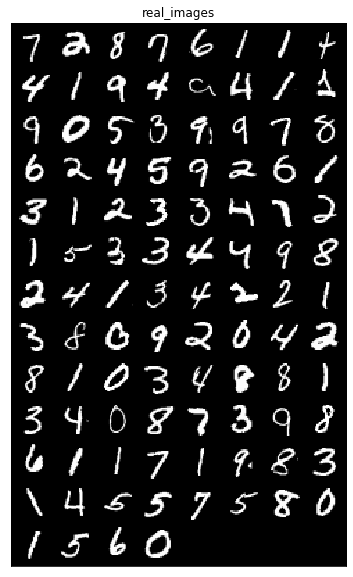

In [6]:
img = mpimg.imread('samples/real_images.png')
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title("real_images")
plt.show()

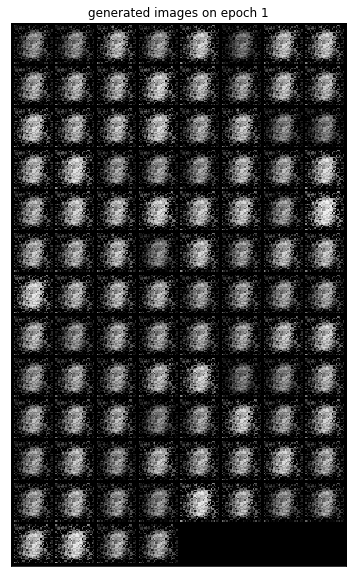

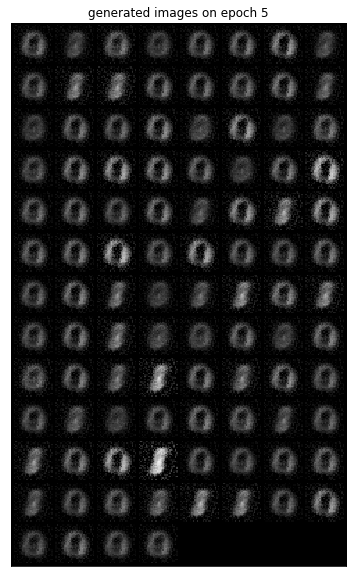

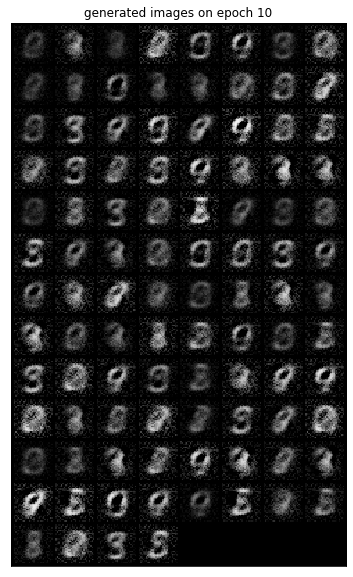

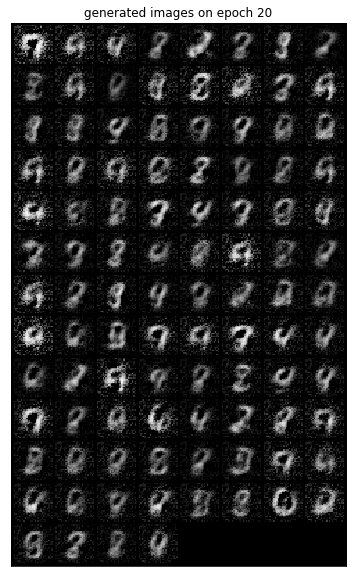

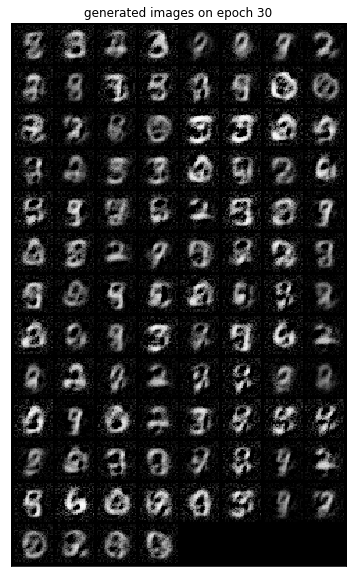

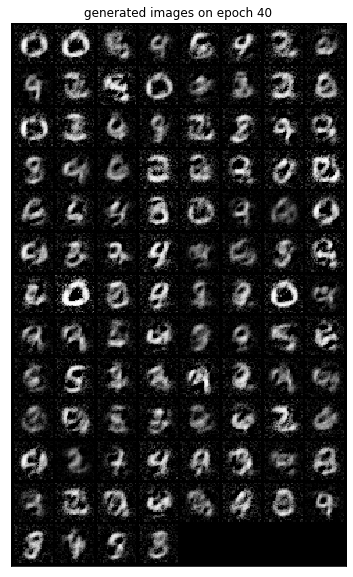

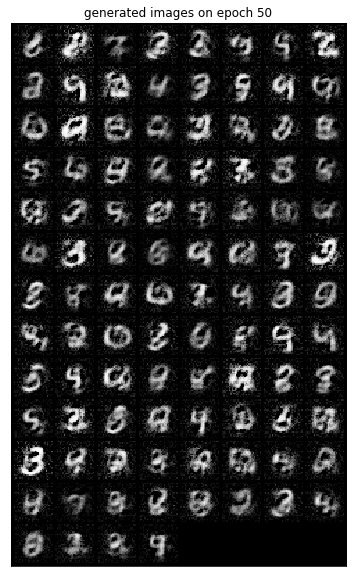

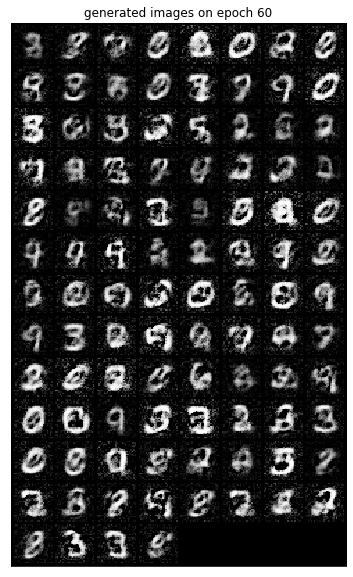

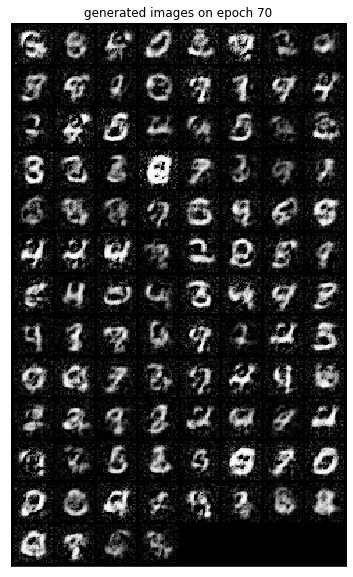

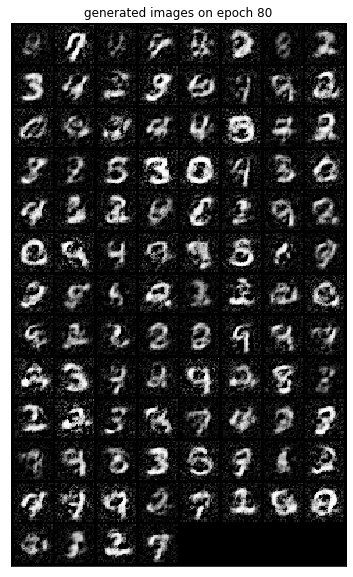

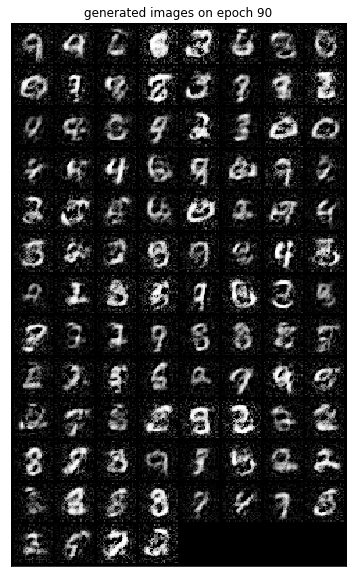

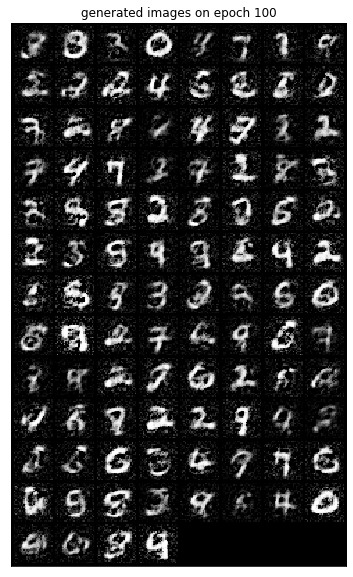

In [7]:
for epoch in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    img = mpimg.imread('samples/fake_images-{}.png'.format(epoch))
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title("generated images on epoch {}".format(epoch))
    plt.show()